In [9]:
import numpy as np
from sklearn.mixture import GaussianMixture
from scipy.stats import norm
from scipy.integrate import quad

import h5py as h5
import arepo
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm
from scipy.interpolate import interp1d
from scipy.stats import binned_statistic_2d
from numba import njit
import os
from joblib import Parallel, delayed
import warnings
from scipy.interpolate import CubicSpline
from scipy.stats import norm

from astropy.io import fits
import astropy.coordinates as coord
import astropy.units as u

basepath = '/n/holylfs05/LABS/hernquist_lab/Users/abeane/GSEgas/'

import sys
sys.path.append(basepath+'note/')
import galaxy

from scipy.ndimage import gaussian_filter

import illustris_python as il
TNGbase = '/n/holylfs05/LABS/hernquist_lab/IllustrisTNG/Runs/L35n2160TNG/output/'

In [2]:
mpl.rc('text', usetex=True)
mpl.rc('text.latex', preamble=r"""
\usepackage{amsmath}
""")
# mpl.rcParams.update({'font.size': 22})
# mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']
# color palette
tb_c = ['#4e79a7', '#f28e2b', '#e15759', '#76b7b2', '#59a14f',
        '#edc948', '#b07aa1', '#ff9da7', '#9c755f', '#bab0ac']

columnwidth = 242.26653 / 72.27 # converts pts to inches
textwidth = 513.11743 / 72.27

mpl.rcParams.update({'font.size': 8})

In [3]:
GFM_SOLAR_ABUNDANCE_HYDROGEN = 0.7388
GFM_SOLAR_ABUNDANCE_MAGNESIUM = 0.0007
GFM_SOLAR_ABUNDANCE_IRON   =   0.0013

In [4]:
def load_galaxy(sim, sd=None, idx=320):
    if sim=='iso':
        key = 'lvl4-Ngb64'
        output_dir = basepath + 'runs/MW7iso/'+ key + '/output'
    elif sd is not None:
        key = 'lvl4-sd'+str(sd)
        output_dir = basepath + 'runs/MW7_GSE4-Rs'+sim[0]+'-Vv'+sim[1]+'-ecc'+sim[2]+'-lvl4/' + key + '/output'
    else:
        key = 'lvl4-'+'Rs'+sim[0]+'-Vv'+sim[1]+'-e'+sim[2]
        output_dir = basepath + 'runs/MW7_GSE4-eRVgrid-lvl4/' + key + '/output'
    return galaxy.Galaxy(output_dir, idx, orient=True)

In [5]:
allgal = {}
for Rs in tqdm(['116', '129', '142'], leave=True, position=0):
    allgal[Rs] = {}
    for Vv in ['116', '129', '142']:
        allgal[Rs][Vv] = {}
        for ecc in ['04', '05', '06']:
            sim = (Rs, Vv, ecc)
            allgal[Rs][Vv][ecc] = load_galaxy(sim)
            
allgal['iso'] = load_galaxy('iso')

100%|██████████| 3/3 [00:53<00:00, 17.90s/it]


In [6]:
def extract_sim_data(gal, no_SN=False):
    sn = gal.sn
    
    ### get logFeH and logMgFe ###
    FeH = sn.part4.GFM_Metals[:,8] / GFM_SOLAR_ABUNDANCE_IRON
    MgH = sn.part4.GFM_Metals[:,6] / GFM_SOLAR_ABUNDANCE_MAGNESIUM
    
    logFeH = np.log10(FeH)
    logMgH = np.log10(MgH)
    logMgFe = logMgH - logFeH

    ### get in_SN ###
    Lzsun = 8 * 220 * 0.2
    zmax = 3
    dLz = 0.3
    
    Lz = np.cross(sn.part4.rotpos, sn.part4.rotvel)[:,2]
    in_SN = np.logical_and(np.abs((Lz/Lzsun)-1) < dLz, np.abs(sn.part4.rotpos[:,2]) < zmax)
    
    if no_SN:
        mask = np.full_like(in_SN, True)
    else:
        mask = in_SN
    
    ### get tform ###
    tform = sn.part4.GFM_StellarFormationTime
    keybool = np.logical_and(mask, tform > 0)
    
    out = {}
    out['logFeH'] = logFeH[mask]
    out['logMgFe'] = logMgFe[mask]
    out['GFM_StellarFormationTime'] = sn.part4.GFM_StellarFormationTime[mask]
    out['BirthMass'] = sn.part4.GFM_InitialMass[mask]
    # out['Pos'] = sn.part4.Coordinates[mask]
    # out['BirthPos'] = sn.part4.BirthPos[mask]
    out['in_SN'] = in_SN
    
    # load com as fn of time
    # time, com0, com1 = find_com(sd)
    # com = np.load('centering/sim_'+sim[0]+'_'+sim[1]+'_'+sim[2]+'_seed'+str(sd)+'.npy', allow_pickle=True).item()
    # out['COM'] = {}
    # for k in com.keys():
        # out['COM'][k] = com[k]
    
    return out

In [7]:
allsimdat = {}
for Rs in tqdm(['116', '129', '142'], leave=True, position=0):
    allsimdat[Rs] = {}
    for Vv in ['116', '129', '142']:
        allsimdat[Rs][Vv] = {}
        for ecc in ['04', '05', '06']:
            sim = (Rs, Vv, ecc)
            allsimdat[Rs][Vv][ecc] = extract_sim_data(allgal[Rs][Vv][ecc], no_SN=True)

allsimdat['iso'] = extract_sim_data(allgal['iso'], no_SN=True)

100%|██████████| 3/3 [00:00<00:00,  5.27it/s]


In [13]:
def get_gaussian_fit(simdat, dt=0.2, logFeH0 = 0, dlogFeH = 0.1):
    tform   = simdat['GFM_StellarFormationTime']
    logMgFe = simdat['logMgFe']
    logFeH  = simdat['logFeH']
    
    mask = np.logical_and(logFeH > logFeH0 - dlogFeH/2., logFeH < logFeH0 + dlogFeH/2.)
    mask = np.logical_and(mask, simdat['in_SN'])
    
    tbins = np.arange(0, 8+dt, dt)
    tcen = 0.5 * (tbins[1:] + tbins[:-1])
    
    mu_list = []
    sigma_list = []
    amp_list = []
    
    for t0 in tbins[:-1]:
        mask_att0 = np.logical_and(tform > t0, tform < t0 + dt)
        mask_att0 = np.logical_and(mask, mask_att0)
        
        amp = np.sum(mask_att0)
        if amp > 10:
            mu, sigma = norm.fit(logMgFe[mask_att0])
        else:
            mu, sigma = np.nan, np.nan
        
        mu_list.append(mu)
        sigma_list.append(sigma)
        amp_list.append(amp)
    
    out = {}
    out['tcen'] = np.array(tcen)
    out['mu'] = np.array(mu_list)
    out['sigma'] = np.array(sigma_list)
    out['amp'] = np.array(amp_list)
    
    return out
    

In [19]:
allgaussfit = {}
for Rs in tqdm(['116', '129', '142'], leave=True, position=0):
    allgaussfit[Rs] = {}
    for Vv in ['116', '129', '142']:
        allgaussfit[Rs][Vv] = {}
        for ecc in ['04', '05', '06']:
            sim = (Rs, Vv, ecc)
            allgaussfit[Rs][Vv][ecc] = get_gaussian_fit(allsimdat[Rs][Vv][ecc])

allgaussfit['iso'] = get_gaussian_fit(allsimdat['iso'])

100%|██████████| 3/3 [00:00<00:00,  5.05it/s]


[(0.0, 817.95)]

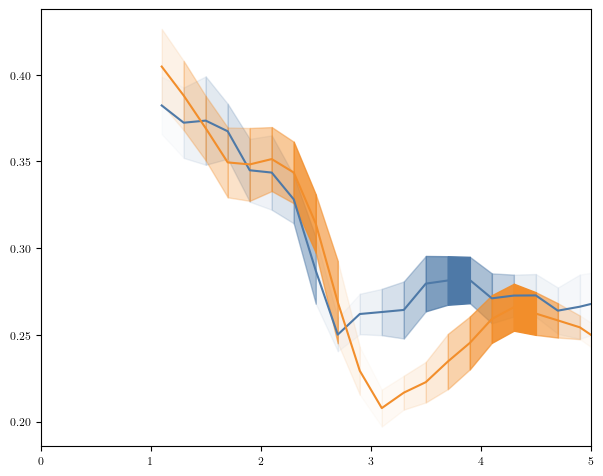

In [39]:
sim_uni = ('129', '116', '05')
sim_bi  = ('116', '142', '05')

gfit_uni = allgaussfit[sim_uni[0]][sim_uni[1]][sim_uni[2]]
gfit_bi  = allgaussfit[sim_bi[0]][sim_bi[1]][sim_bi[2]]

fig, ax = plt.subplots(1, 1, figsize=(textwidth, 0.8*textwidth))

# ax.plot(gfit_uni['tcen'], gfit_uni['mu']/gfit_uni['sigma'], c=tb_c[0])
# ax.plot(gfit_uni['tcen'], gfit_bi['mu']/gfit_bi['sigma'], c=tb_c[0], ls='dashed')

for gfit,c in zip([gfit_uni, gfit_bi], [tb_c[0], tb_c[1]]):
    ax.plot(gfit['tcen'], gfit['mu'], c=c)

    amp_norm = gfit['amp'] / np.max(gfit['amp'])
    mu_plus_sigma  = gfit['mu'] + gfit['sigma']
    mu_minus_sigma = gfit['mu'] - gfit['sigma']
    time = gfit['tcen']

    for i in range(len(time) - 1):
        ax.fill_between(
            time[i:i+2], 
            mu_minus_sigma[i:i+2], 
            mu_plus_sigma[i:i+2], 
            color=c, 
            alpha=amp_norm[i]
        )

# ax.fill_between(gfit_uni['tcen'], gfit_uni['mu']-gfit_uni['sigma'], 
                                  # gfit_uni['mu']+gfit_uni['sigma'], color=tb_c[0], alpha=0.5)


# ax.fill_between(gfit_bi['tcen'], gfit_bi['mu']-gfit_bi['sigma'], 
                                  # gfit_bi['mu']+gfit_bi['sigma'], color=tb_c[1], alpha=0.5)

# ax2 = ax.twinx()
# ax2.plot(gfit_uni['tcen'], gfit_uni['amp'], c=tb_c[1])
# ax2.plot(gfit_bi['tcen'],  gfit_bi['amp'],  c=tb_c[1], ls='dashed')

ax.set(xlim=(0, 5))
ax2.set(ylim=(0, None))

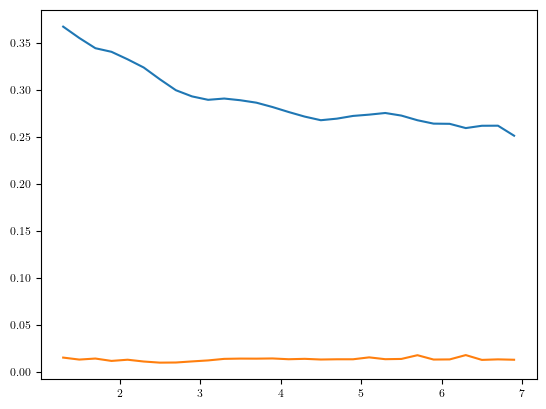

In [17]:
fig, ax = plt.subplots(

plt.plot(gauss_fit['tcen'], gauss_fit['mu'])
plt.plot(gauss_fit['tcen'], gauss_fit['sigma'])
plt.plot(gauss_fit

In [8]:
allsimdat['iso']

{'logFeH': array([ 0.5233251 , -0.51129   , -0.2047634 , ...,  0.12079941,
        -0.23195575, -0.16677916], dtype=float32),
 'logMgFe': array([0.21712601, 0.4261589 , 0.40587714, ..., 0.14581329, 0.25872904,
        0.24423589], dtype=float32),
 'GFM_StellarFormationTime': array([ 4.8701477,  1.1248779,  1.0647583, ..., -0.0087793,  6.395874 ,
         7.1339417], dtype=float32),
 'BirthMass': Quantity([7.97001286e-06, 6.49682711e-06, 5.78722588e-06, ...,
           6.65792726e-06, 4.46682662e-06, 8.87952271e-06], unit=[1e+10 Msol]),
 'in_SN': array([False, False, False, ...,  True, False, False])}

In [10]:
norm.fit(allsimdat['iso']['logMgFe'])

(0.3127923, 0.09756109)